In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
import pmdarima as pm
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
train = pd.read_csv("train.csv", index_col = 'Date', parse_dates=['Date'])
test = pd.read_csv("test.csv", index_col = 'Date')

# train_big = pd.read_csv("train.csv", index_col = 'Date', parse_dates=['Date'])
# train = train_big.iloc[0:(len(train_big)-30)]
# test = train_big.iloc[len(train):(len(train_big)-1)]

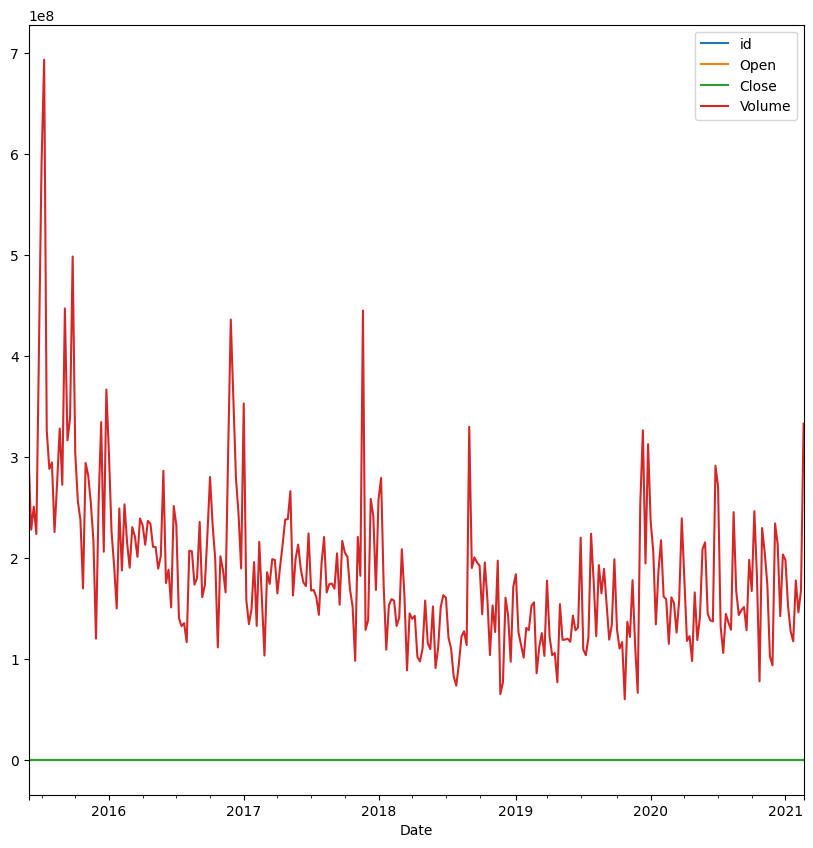

In [3]:
train.plot(figsize=(10,10))
plt.show()

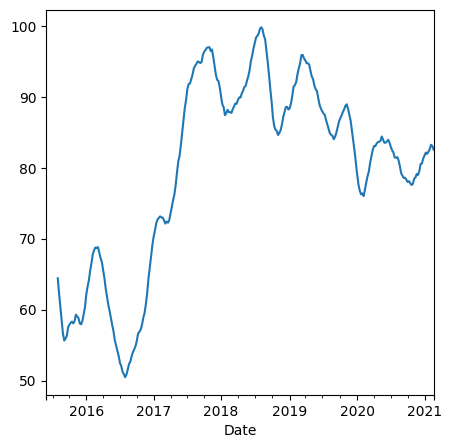

In [4]:
roll = train.Close.rolling(window=10).mean()
roll.plot(figsize=(5,5))
plt.show()

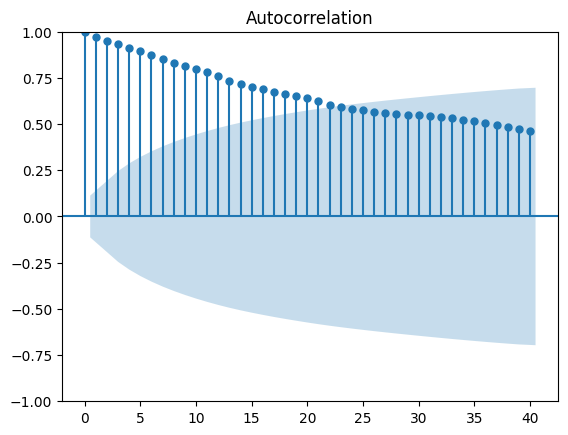

In [5]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train['Close'], lags=40)
plt.show()

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

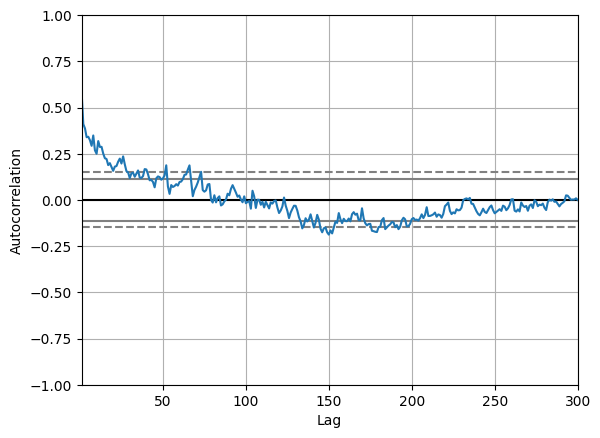

In [6]:
lag_plot(train['Volume'].sample(250))
autocorrelation_plot(train['Volume'])

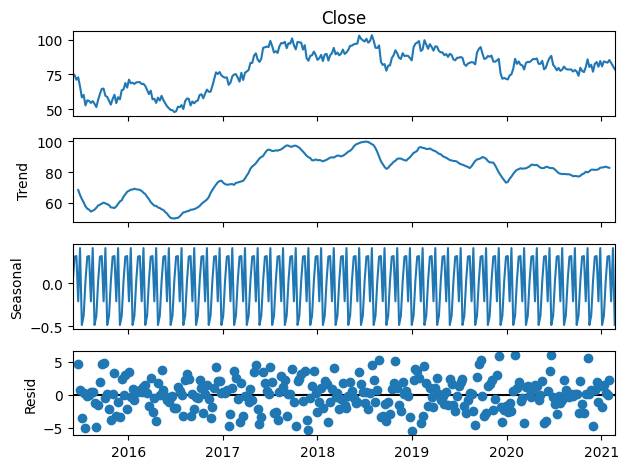

In [7]:
# Decompose the time series into its components
decomposition = sm.tsa.seasonal_decompose(train['Close'], model='additive',period=7)
decomposition.plot()

# Plot the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

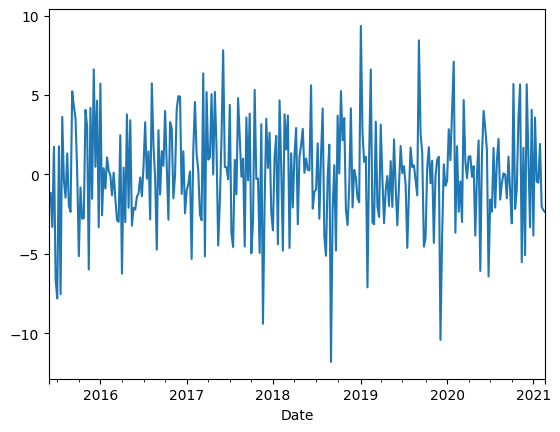

In [8]:
from statsmodels.tsa.stattools import adfuller

series = train['Close']
adfuller(series)
# first order differencing
diff = series.diff()
diff.plot()
plt.show()


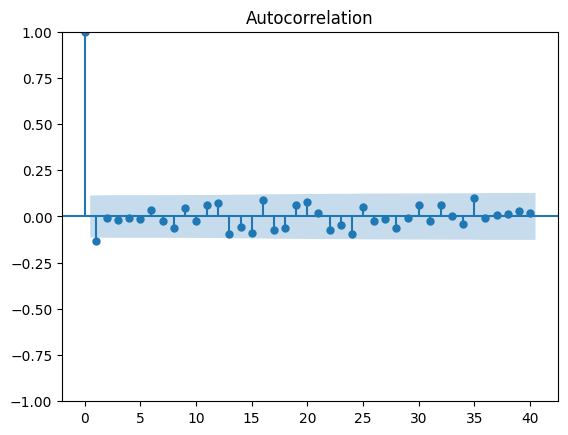

In [9]:
adfuller(diff.dropna())
# from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(diff.dropna(), lags=40)
plt.show()

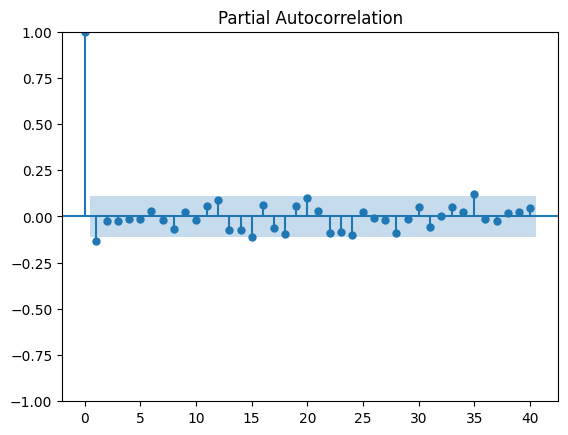

In [10]:
fig = tsaplots.plot_pacf(diff.dropna(), lags=40)
plt.show()

In [11]:
# SARIMAX MODEL 1
arima_order = (4,1,2)
endog = train.Close
exog = sm.add_constant(train[['Open','Volume']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, train_exog=exog, order=arima_order)
model_fit = mod.fit()

test_exog = sm.add_constant(test[['Open','Volume']])
sarimax_forecast = model_fit.forecast(exog=test_exog,steps=100)
print(sarimax_forecast.head())



C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['train_exog']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as st

2021-03-01    78.903427
2021-03-08    77.941496
2021-03-15    77.766755
2021-03-22    78.592379
2021-03-29    79.248305
Freq: W-MON, Name: predicted_mean, dtype: float64


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# SARIMAX model 2
# new order, but same exogenous variables
endog = train.Close
arima_order = (1,0,1)
seasonal_o = (4,0,4,5)
exog = sm.add_constant(train[['Open','Volume']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, train_exog=exog, order=arima_order,seasonal_order=seasonal_o)
model_fit = mod.fit()

test_exog = sm.add_constant(test[['Open','Volume']])
sarimax_forecast3 = model_fit.forecast(exog=test_exog,steps=100)
sarimax3_train = model_fit.forecast(exog=exog,steps=100)
print(sarimax_forecast3.head())


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['train_exog']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting pa

2021-03-01    79.535901
2021-03-08    79.579769
2021-03-15    80.264688
2021-03-22    79.852723
2021-03-29    80.129403
Freq: W-MON, Name: predicted_mean, dtype: float64


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


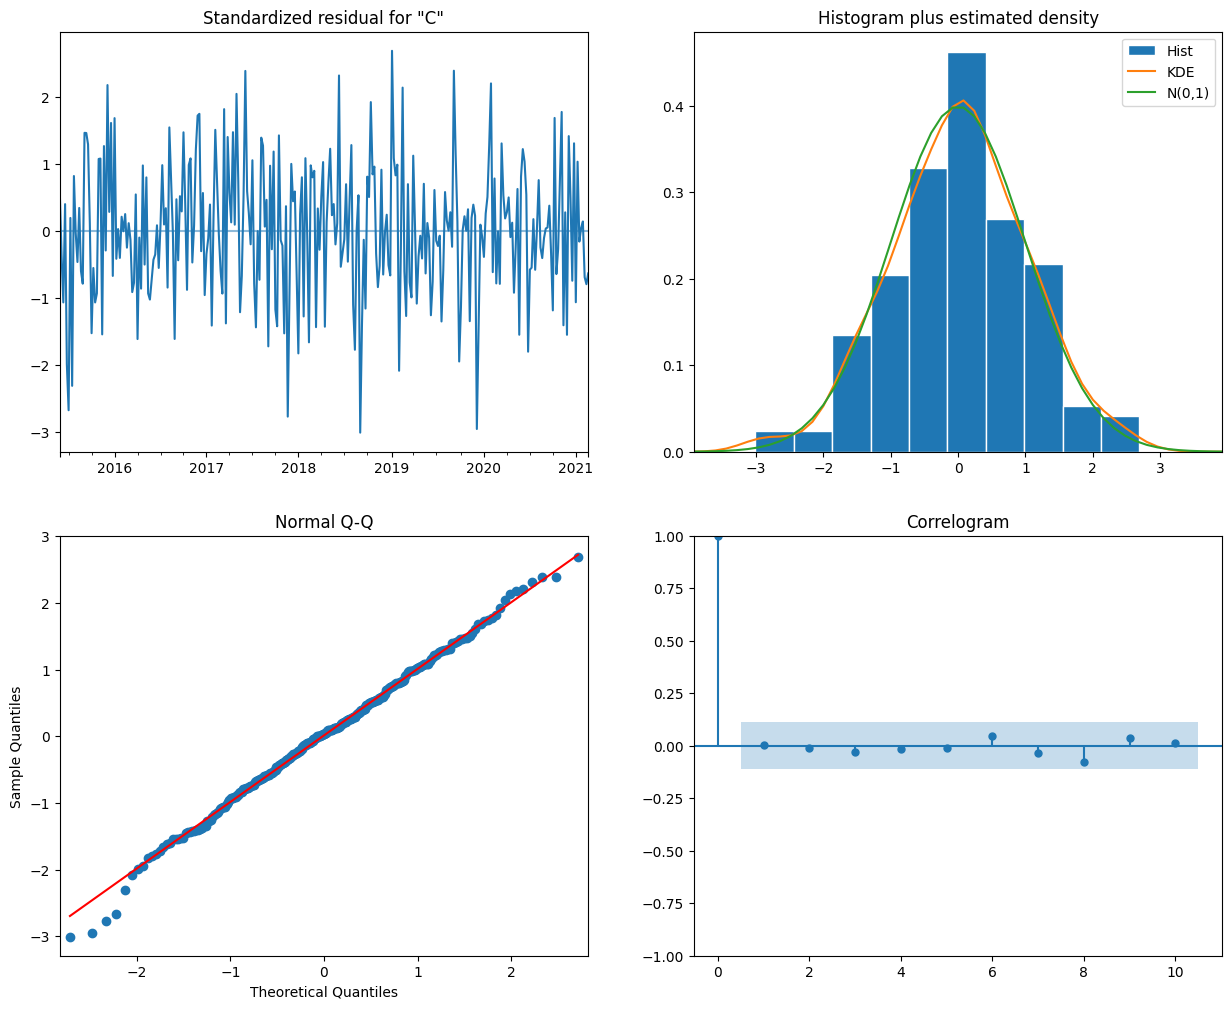

In [13]:
model_fit .plot_diagnostics(figsize=(15,12))
plt.show()

In [14]:
def findMovingAvg(datas,column, win):
    moving_avg = datas[column].rolling(window=win).mean()
    return moving_avg

In [15]:
def openCloseAvg(data):
    new_data = data.copy()
    new_data['average_price'] = (new_data['Open'] + new_data['Close']) / 2
    return new_data['average_price']

In [16]:
def getMAUsingTrainTest(train,test,column,win):
    merged = pd.concat([train,test])
    merged_moving_avg = findMovingAvg(merged,column,win)
    merged[f'{column}MovingAvg_{win}'] = merged_moving_avg
    together = pd.merge(test,merged[f'{column}MovingAvg_{win}'],on='Date',how='inner')
    return together[f'{column}MovingAvg_{win}']

In [17]:
def getLagged(datas,column,lag):
    datas[f'{column}Lag_{lag}'] = datas[column].shift(1)
    datas = datas.dropna(subset=f'{column}Lag_{lag}')
    return datas[f'{column}Lag_{lag}']

In [18]:
def getTrainTestlag(train,test,column,lag):
    merged = pd.concat([train,test])
    merged_lag = getLagged(merged,column,lag)
    merged[f'{column}Lag_{lag}'] = merged_lag
    together = pd.merge(test,merged[f'{column}Lag_{lag}'],on='Date',how='inner')
    return together[f'{column}Lag_{lag}']

In [19]:
def getRSI(train,column,win):
    delta = train[column].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=win).mean()
    avg_loss = loss.rolling(window=win).mean()
    rs = avg_gain / avg_loss
    train[f'{column}RSI'] = 100 - (100 / (1 + rs))
    return train[f'{column}RSI']

In [20]:
def getRSITrainTest(train,test,column,win):
    merged = pd.concat([train,test])
    delta = merged[column].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=win).mean()
    avg_loss = loss.rolling(window=win).mean()
    rs = avg_gain / avg_loss
    merged[f'{column}RSI'] = 100 - (100 / (1 + rs))
    together = pd.merge(test,merged[f'{column}RSI'],on='Date',how='inner')
    return together[f'{column}RSI']

In [21]:
def getGain(train,column):
    delta = train[column].diff()
    return delta

In [22]:
def getGainTrainTest(train,test,column):
    merged = pd.concat([train,test])
    delta = merged[column].diff()
    merged[f'delta'] = delta
    together = pd.merge(test,merged['delta'],on='Date',how='inner')
    return together[f'delta']

In [23]:
def getEMA(data, column, win):
    data[f'EMA_{column}'] = data[column].ewm(span=win, adjust=False).mean()
    return data[f'EMA_{column}']

In [24]:
train_dataset = train.copy()
# train_dataset['VolumeMovingAvg_12'] = findMovingAvg(train,'Volume',12)
# train_dataset['VolumeLag_1'] = getLagged(train,'Volume',1)
train_dataset['OpenMovingAvg_4'] = findMovingAvg(train,'Open',4)
train_dataset['OpenRSI'] = getRSI(train,'Open',4)
train_dataset['OpenLag_1'] = getLagged(train,'Open',1)
train_dataset['Gain'] = getGain(train,'Open')
train_dataset.dropna(inplace=True)
train_dataset


,id,Open,Close,Volume,Strategy,OpenMovingAvg_4,OpenRSI,OpenLag_1,Gain
Date,,,,,,,,,
2015-06-22,3,54.754816,72.881344,223614300,Hold,58.195370,27.594033,47.701942,7.052875
2015-06-29,4,48.031899,66.284718,406814900,Buy,53.651223,21.847473,54.754816,-6.722917
2015-07-06,5,51.374399,58.494017,590857400,Buy,50.465764,31.000813,48.031899,3.342499
2015-07-13,6,45.851376,60.269347,693570200,Buy,50.003123,45.913298,51.374399,-5.523023
2015-07-20,7,45.200332,52.738477,326224700,Buy,47.614501,20.582547,45.851376,-0.651044
...,...,...,...,...,...,...,...,...,...
2021-01-25,295,81.284821,83.373498,117281600,Sell,80.569815,50.111466,80.663736,0.621085
2021-02-01,296,71.970249,85.294903,177655800,Sell,78.439755,12.661490,81.284821,-9.314572
2021-02-08,297,71.784627,83.266453,146003500,Hold,76.425859,13.199020,71.970249,-0.185622


In [25]:
train_y = train_dataset.Close
train_strat = train_dataset.Strategy
del train_dataset['Close']
del train_dataset['Strategy']
del train_dataset['id']

In [26]:
test_dataset = test.copy()
test_dataset['OpenMovingAvg_4'] = getMAUsingTrainTest(train,test,'Open',4)
test_dataset['OpenLag_1'] = getTrainTestlag(train,test,'Open',4)
test_dataset['OpenRSI'] = getRSITrainTest(train,test,'Open',4)
test_dataset['Gain'] = getGainTrainTest(train,test,'Open')
del test_dataset['id']

test_dataset

,Open,Volume,OpenMovingAvg_4,OpenLag_1,OpenRSI,Gain
Date,,,,,,
2021-03-01,72.708331,205897600,70.870978,69.618620,56.219181,3.089711
2021-03-08,73.310886,214095600,71.252543,72.708331,62.016181,0.602555
2021-03-15,70.610119,151601700,71.561989,73.310886,59.321632,-2.700767
2021-03-22,70.256017,193982500,71.721338,70.610119,54.723462,-0.354102
2021-03-29,68.258324,220238400,70.608836,70.256017,10.655038,-1.997693
...,...,...,...,...,...,...
2022-12-26,57.048622,224994700,57.519659,55.184092,43.933788,1.864530
2023-01-02,60.569661,176020500,57.805033,57.048622,55.926990,3.521039
2023-01-09,61.446777,181478600,58.562288,60.569661,65.948335,0.877116


In [27]:
print((train_dataset.columns))
print((test_dataset.columns))

Index(['Open', 'Volume', 'OpenMovingAvg_4', 'OpenRSI', 'OpenLag_1', 'Gain'], dtype='object')
Index(['Open', 'Volume', 'OpenMovingAvg_4', 'OpenLag_1', 'OpenRSI', 'Gain'], dtype='object')


In [28]:
null_values = train_dataset.isnull().sum()
null_values

Open               0
Volume             0
OpenMovingAvg_4    0
OpenRSI            0
OpenLag_1          0
Gain               0
dtype: int64

In [29]:
train_endog = train_y
train_exog = train_dataset
train_exog = train_exog.dropna(inplace=True)

# for test, moving avg from train data is also considered
# e =  getMAUsingTrainTest(train,test,ma_window)
test_exog = test_dataset

In [30]:
train_dataset

,Open,Volume,OpenMovingAvg_4,OpenRSI,OpenLag_1,Gain
Date,,,,,,
2015-06-22,54.754816,223614300,58.195370,27.594033,47.701942,7.052875
2015-06-29,48.031899,406814900,53.651223,21.847473,54.754816,-6.722917
2015-07-06,51.374399,590857400,50.465764,31.000813,48.031899,3.342499
2015-07-13,45.851376,693570200,50.003123,45.913298,51.374399,-5.523023
2015-07-20,45.200332,326224700,47.614501,20.582547,45.851376,-0.651044
...,...,...,...,...,...,...
2021-01-25,81.284821,117281600,80.569815,50.111466,80.663736,0.621085
2021-02-01,71.970249,177655800,78.439755,12.661490,81.284821,-9.314572
2021-02-08,71.784627,146003500,76.425859,13.199020,71.970249,-0.185622


In [31]:
train_dataset = train_dataset.sort_index(axis=1)
test_dataset= test_dataset.sort_index(axis=1)

In [32]:
mod3 = sm.tsa.statespace.SARIMAX(endog=train_endog, exog=train_dataset, order=arima_order,seasonal_order=seasonal_o)
model_fit3 = mod3.fit()

close_ma_lag = model_fit3.forecast(exog=test_dataset,steps=100)
close_ma_lag.tolist()

C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[74.79813465435805,
 73.11792358380679,
 73.76297584305833,
 75.77776768044558,
 75.33161532617557,
 74.13579430604524,
 71.94922101386219,
 71.37375198837832,
 73.56273666764076,
 74.1274412581346,
 73.1988721112638,
 71.6681572923902,
 71.94250777570917,
 72.5038236991515,
 73.79284666193905,
 75.35394592243621,
 74.60396536662658,
 74.84602435747502,
 71.73755505134463,
 68.7011428069319,
 70.25441857723284,
 72.27885867837205,
 74.23642796533672,
 76.02107409186563,
 78.19342815638876,
 80.14793697594612,
 80.39808903775734,
 81.25239204706132,
 82.4357669069285,
 80.47591874590768,
 81.64846886751066,
 81.76463910490378,
 80.33368411691579,
 80.56571744033714,
 82.43186547794654,
 85.27433361517507,
 84.1808807942305,
 87.11715229623144,
 83.86365078355216,
 84.59321153299155,
 90.39845150507624,
 85.39625254923945,
 79.38275924273053,
 77.9711168532335,
 74.31055312004722,
 75.26165766511333,
 73.49067415599751,
 70.20375419028089,
 71.54811143910757,
 74.13356315641283,
 76.0765

In [33]:
test_dataset

,Gain,Open,OpenLag_1,OpenMovingAvg_4,OpenRSI,Volume
Date,,,,,,
2021-03-01,3.089711,72.708331,69.618620,70.870978,56.219181,205897600
2021-03-08,0.602555,73.310886,72.708331,71.252543,62.016181,214095600
2021-03-15,-2.700767,70.610119,73.310886,71.561989,59.321632,151601700
2021-03-22,-0.354102,70.256017,70.610119,71.721338,54.723462,193982500
2021-03-29,-1.997693,68.258324,70.256017,70.608836,10.655038,220238400
...,...,...,...,...,...,...
2022-12-26,1.864530,57.048622,55.184092,57.519659,43.933788,224994700
2023-01-02,3.521039,60.569661,57.048622,57.805033,55.926990,176020500
2023-01-09,0.877116,61.446777,60.569661,58.562288,65.948335,181478600


In [34]:
train_strategy_x = train_dataset.copy()
train_strategy_x['CloseMovingAvg_12'] = findMovingAvg(train,'Close',12)
train_strategy_x['CloseMovingAvg_4'] = findMovingAvg(train,'Close',4)
train_strategy_x['CloseRSI'] = getRSI(train,'Close',4)
train_strategy_x['CloseLag_1'] = getLagged(train,'Close',1)
train_strategy_x['Close_EMA4'] = getEMA(train, 'Close',4)
train_strategy_x['OpenCloseAvg'] = openCloseAvg(train)
train_strategy_x

,Gain,Open,OpenLag_1,OpenMovingAvg_4,OpenRSI,Volume,CloseMovingAvg_12,CloseMovingAvg_4,CloseRSI,CloseLag_1,Close_EMA4,OpenCloseAvg
Date,,,,,,,,,,,,
2015-06-22,7.052875,54.754816,47.701942,58.195370,27.594033,223614300,NaN,73.518871,28.029110,71.140831,73.277932,63.818080
2015-06-29,-6.722917,48.031899,54.754816,53.651223,21.847473,406814900,NaN,71.187556,13.591078,72.881344,70.480646,57.158309
2015-07-06,3.342499,51.374399,48.031899,50.465764,31.000813,590857400,NaN,67.200227,8.957703,66.284718,65.685994,54.934208
2015-07-13,-5.523023,45.851376,51.374399,50.003123,45.913298,693570200,NaN,64.482356,19.638101,58.494017,63.519335,53.060361
2015-07-20,-0.651044,45.200332,45.851376,47.614501,20.582547,326224700,NaN,59.446640,7.492892,60.269347,59.206992,48.969405
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.621085,81.284821,80.663736,80.569815,50.111466,117281600,82.389456,83.082155,42.778045,83.889750,83.315981,82.329159
2021-02-01,-9.314572,71.970249,81.284821,78.439755,12.661490,177655800,82.349165,84.220637,85.270425,83.373498,84.107550,78.632576
2021-02-08,-0.185622,71.784627,71.970249,76.425859,13.199020,146003500,82.599522,83.956151,39.206291,85.294903,83.771111,77.525540


In [35]:
test_strategy_x = test_dataset.copy()
test_dataset['Close'] = close_ma_lag
test_strategy_x['CloseMovingAvg_12'] = getMAUsingTrainTest(train,test,'Close',12)
test_strategy_x['CloseMovingAvg_4'] = getMAUsingTrainTest(train,test,'Close',12)
test_strategy_x['CloseRSI'] = getRSI(test_dataset,'Close',4)
test_strategy_x['CloseLag_1'] = getLagged(test_dataset,'Close',1)
test_strategy_x['Close_EMA4'] = getEMA(test_dataset, 'Close',4)
test_strategy_x['OpenCloseAvg'] = openCloseAvg(test_dataset)
test_strategy_x

,Gain,Open,OpenLag_1,OpenMovingAvg_4,OpenRSI,Volume,CloseMovingAvg_12,CloseMovingAvg_4,CloseRSI,CloseLag_1,Close_EMA4,OpenCloseAvg
Date,,,,,,,,,,,,
2021-03-01,3.089711,72.708331,69.618620,70.870978,56.219181,205897600,NaN,NaN,NaN,NaN,74.798135,73.753233
2021-03-08,0.602555,73.310886,72.708331,71.252543,62.016181,214095600,NaN,NaN,NaN,74.798135,74.126050,73.214405
2021-03-15,-2.700767,70.610119,73.310886,71.561989,59.321632,151601700,NaN,NaN,NaN,73.117924,73.980820,72.186547
2021-03-22,-0.354102,70.256017,70.610119,71.721338,54.723462,193982500,NaN,NaN,61.285951,73.762976,74.699599,73.016892
2021-03-29,-1.997693,68.258324,70.256017,70.608836,10.655038,220238400,NaN,NaN,55.573104,75.777768,74.952406,71.794970
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.864530,57.048622,55.184092,57.519659,43.933788,224994700,NaN,NaN,95.565247,61.539969,60.232149,59.107167
2023-01-02,3.521039,60.569661,57.048622,57.805033,55.926990,176020500,NaN,NaN,56.391713,61.165711,59.550500,59.548844
2023-01-09,0.877116,61.446777,60.569661,58.562288,65.948335,181478600,NaN,NaN,16.049788,58.528027,58.811492,59.574878


In [36]:
print(len(train_strategy_x.columns))
print(len(test_strategy_x.columns))

12
12


In [37]:
# this model did not give good accuracy. But keeping this for memories
def randomForestStrategyWithMALag(train,test,close_forecast):
    clf = RandomForestClassifier(n_estimators=100)
    X_train = train[['Open','Volume','MovingAvg_12','MovingAvg_4','OpenLag_1','VolumeLag_1','Close']]
    y_train = train['Strategy']
    clf.fit(X_train, y_train)

    test['Close'] = close_forecast.tolist()
    X_test = test[['Open','Volume','MovingAvg_12','MovingAvg_4','OpenLag_1','VolumeLag_1''Close']]
    strategy_pred = clf.predict(X_test)
    return strategy_pred

In [38]:
import xgboost as xgb

def xgboostClassifier(train_dataset,train_y,test,close_forecast):
    xgboost = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                            min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

    xgboost.fit(train_dataset, train_y)
    # test['Close'] = close_forecast.tolist()
    preds = xgboost.predict(test)
    return preds

In [39]:
test_strategy_x

,Gain,Open,OpenLag_1,OpenMovingAvg_4,OpenRSI,Volume,CloseMovingAvg_12,CloseMovingAvg_4,CloseRSI,CloseLag_1,Close_EMA4,OpenCloseAvg
Date,,,,,,,,,,,,
2021-03-01,3.089711,72.708331,69.618620,70.870978,56.219181,205897600,NaN,NaN,NaN,NaN,74.798135,73.753233
2021-03-08,0.602555,73.310886,72.708331,71.252543,62.016181,214095600,NaN,NaN,NaN,74.798135,74.126050,73.214405
2021-03-15,-2.700767,70.610119,73.310886,71.561989,59.321632,151601700,NaN,NaN,NaN,73.117924,73.980820,72.186547
2021-03-22,-0.354102,70.256017,70.610119,71.721338,54.723462,193982500,NaN,NaN,61.285951,73.762976,74.699599,73.016892
2021-03-29,-1.997693,68.258324,70.256017,70.608836,10.655038,220238400,NaN,NaN,55.573104,75.777768,74.952406,71.794970
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.864530,57.048622,55.184092,57.519659,43.933788,224994700,NaN,NaN,95.565247,61.539969,60.232149,59.107167
2023-01-02,3.521039,60.569661,57.048622,57.805033,55.926990,176020500,NaN,NaN,56.391713,61.165711,59.550500,59.548844
2023-01-09,0.877116,61.446777,60.569661,58.562288,65.948335,181478600,NaN,NaN,16.049788,58.528027,58.811492,59.574878


In [40]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_strat = label_encoder.fit_transform(train_strat)
print(train_strat.size)
train_dataset


297


,Gain,Open,OpenLag_1,OpenMovingAvg_4,OpenRSI,Volume
Date,,,,,,
2015-06-22,7.052875,54.754816,47.701942,58.195370,27.594033,223614300
2015-06-29,-6.722917,48.031899,54.754816,53.651223,21.847473,406814900
2015-07-06,3.342499,51.374399,48.031899,50.465764,31.000813,590857400
2015-07-13,-5.523023,45.851376,51.374399,50.003123,45.913298,693570200
2015-07-20,-0.651044,45.200332,45.851376,47.614501,20.582547,326224700
...,...,...,...,...,...,...
2021-01-25,0.621085,81.284821,80.663736,80.569815,50.111466,117281600
2021-02-01,-9.314572,71.970249,81.284821,78.439755,12.661490,177655800
2021-02-08,-0.185622,71.784627,71.970249,76.425859,13.199020,146003500


In [41]:
# del test_strategy_x['Close']

In [42]:
train_strategy_x = train_strategy_x.sort_index(axis=1)
test_strategy_x = test_strategy_x.sort_index(axis=1)
print((train_strategy_x.columns))
print((test_strategy_x.columns))

train_strat

Index(['CloseLag_1', 'CloseMovingAvg_12', 'CloseMovingAvg_4', 'CloseRSI',
       'Close_EMA4', 'Gain', 'Open', 'OpenCloseAvg', 'OpenLag_1',
       'OpenMovingAvg_4', 'OpenRSI', 'Volume'],
      dtype='object')
Index(['CloseLag_1', 'CloseMovingAvg_12', 'CloseMovingAvg_4', 'CloseRSI',
       'Close_EMA4', 'Gain', 'Open', 'OpenCloseAvg', 'OpenLag_1',
       'OpenMovingAvg_4', 'OpenRSI', 'Volume'],
      dtype='object')


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1])

In [43]:
# train_strat_dataset = train_dtrain_datasetataset
strat_results = xgboostClassifier(train_strategy_x,train_strat,test_strategy_x,close_ma_lag)

In [44]:
strat_results = label_encoder.inverse_transform(strat_results)

# Now, 'original_class_names' contains the class names
strat_results

array(['Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy',
       'Buy', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold',
       'Hold'], dtype=object)

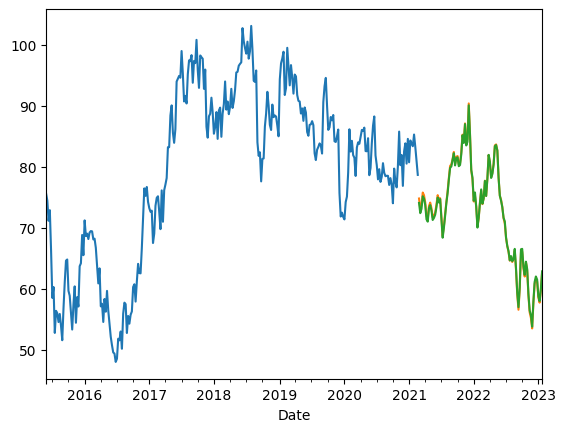

In [51]:
merged = pd.concat([train[250:],test])
# print(train.index)
train.Close.plot()
close_ma_lag.plot()
plt.show()

In [47]:
submission = pd.DataFrame()
submission["Date"] = test.index

In [48]:
submission["Close"] = close_ma_lag.tolist()
submission["Strategy"] = strat_results
submission.head()

,Date,Close,Strategy
0,2021-03-01,74.798135,Hold
1,2021-03-08,73.117924,Buy
2,2021-03-15,73.762976,Hold
3,2021-03-22,75.777768,Hold
4,2021-03-29,75.331615,Hold


In [49]:
submission.to_csv('submission9_gain.csv', index=True,index_label='id')